# **BONUS TRACK 2**
Una vez creada la base de datos haz una o varias consultas para crear un dataframe con los datos relevantes para hacer un análisis de precios entre la competencia y nuestros hoteles para esas fechas. Realiza un análisis temporal de las fechas de reserva

In [1]:
# Importamos librerías y conectamos a la base de datos
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 
import os
from dotenv import load_dotenv
load_dotenv()
dbname = os.getenv("dbname")
user =  os.getenv("user")
password = os.getenv("password")
host = os.getenv("host")
port = os.getenv("port")
# Configurar la conexión
conn = psycopg2.connect(
    dbname = dbname,
    user = user,
    password = password,
    host = host,
    port = port)
# Crear un cursor para ejecutar comandos SQL
cur = conn.cursor()

Vamos a crear dos vistas a partir de la base de datos: una para los hoteles propios y otra para los hoteles de la competencia, de las que obtendremos los datos para nuestro análisis.

In [2]:
query_competencia = """ CREATE VIEW "Vista_hoteles_competencia" AS
                SELECT h.id_hotel, h.nombre_hotel, h.valoracion, r.id_reserva, r.fecha_reserva, r.precio_noche, r.id_cliente
                FROM hoteles AS h
                JOIN reservas AS r on h.id_hotel = r.id_hotel
                WHERE h.competencia = True
              ;"""
cur.execute(query_competencia)
conn.commit
#hoteles_competencia = pd.DataFrame(cur.fetchall(), columns = ["id_hotel", "nombre_hotel", "valoracion", "id_reserva", "fecha_reserva", "precio_noche", "id_cliente"])

<function connection.commit()>

In [3]:
query_propios = """ CREATE VIEW "Vista_hoteles_propios" AS
                SELECT h.id_hotel, h.nombre_hotel, h.valoracion, r.id_reserva, r.fecha_reserva, r.precio_noche, r.id_cliente
                FROM hoteles AS h
                JOIN reservas AS r on h.id_hotel = r.id_hotel
                WHERE h.competencia = False
              ;"""
cur.execute(query_propios)
conn.commit
#hoteles_propios = pd.DataFrame(cur.fetchall(),  columns = ["id_hotel", "nombre_hotel", "valoracion", "id_reserva", "fecha_reserva", "precio_noche", "id_cliente"])

<function connection.commit()>

In [4]:
# Cerramos el cursor y la conexión
#cur.close()
#conn.close()

## Análisis hoteles

### Big Numbers

In [5]:
columnas = ["Cantidad hoteles", "Valoracion media", "Cantidad reservas", "Precio medio", "Ingresos totales"]
valores_propios = []
valores_competencia = []

In [6]:
cuentas_propios = """ SELECT COUNT(DISTINCT id_hotel), COUNT(id_reserva), SUM(precio_noche), AVG(precio_noche), AVG(valoracion)
                    FROM "Vista_hoteles_propios";"""
cur.execute(cuentas_propios)
cuentas_p = cur.fetchall()
cuentas_p

[(19, 9828, 2703317.1433646614, 275.0627944001487, 3.011518111517996)]

In [7]:
cuentas_competencia = """ SELECT COUNT(DISTINCT id_hotel), COUNT(id_reserva), SUM(precio_noche), AVG(precio_noche), AVG(valoracion)
                    FROM "Vista_hoteles_competencia";"""
cur.execute(cuentas_competencia)
cuentas_c = cur.fetchall()
cuentas_c

[(10, 5172, 607800.0, 117.51740139211137, 4.388399071925722)]

In [8]:
cantidad_hoteles = cuentas_p[0][0]
valores_propios.append(cantidad_hoteles)
valoracion = round(cuentas_p[0][4], 1)
valores_propios.append(valoracion)
cantidad_reservas = cuentas_p[0][1]
valores_propios.append(cantidad_reservas)
precio_medio = round(cuentas_p[0][3], 2)
valores_propios.append(precio_medio)
ingresos = round(cuentas_p[0][2], 0)
valores_propios.append(ingresos)

In [9]:
dictio_bnpropios = dict(zip(columnas, valores_propios))
bignumbers_propios = pd.DataFrame(dictio_bnpropios, index = ["propios"], columns = ["Cantidad hoteles", "Valoracion media", "Cantidad reservas", "Precio medio", "Ingresos totales"])

In [10]:
cantidad_hoteles = cuentas_c[0][0]
valores_competencia.append(cantidad_hoteles)
valoracion = round(cuentas_c[0][4], 1)
valores_competencia.append(valoracion)
cantidad_reservas = cuentas_c[0][1]
valores_competencia.append(cantidad_reservas)
precio_medio = round(cuentas_c[0][3], 2)
valores_competencia.append(precio_medio)
ingresos = round(cuentas_c[0][2], 0)
valores_competencia.append(ingresos)

In [11]:
dictio_bncompetencia = dict(zip(columnas, valores_competencia))
bignumbers_competencia = pd.DataFrame(dictio_bncompetencia, index = ["competencia"], columns = ["Cantidad hoteles", "Valoracion media", "Cantidad reservas", "Precio medio", "Ingresos totales"])

In [12]:
BIGNUMBERS = pd.concat([bignumbers_propios, bignumbers_competencia], axis = 0)
BIGNUMBERS

,Cantidad hoteles,Valoracion media,Cantidad reservas,Precio medio,Ingresos totales
propios,19,3.0,9828,275.06,2703317.0
competencia,10,4.4,5172,117.52,607800.0


## Análisis de reservas en hoteles propios

Como la fecha de reservas en los hoteles de la competencia se ha determinado en función de la fecha de scrapeo, solo vamos a analizar los hoteles propios.

In [13]:
# Análisis temporal de las reservas según fecha
query_fechas = """ SELECT 
                fecha_reserva,
                count(id_reserva)
        FROM "Vista_hoteles_propios"
        GROUP BY fecha_reserva; 
"""
cur.execute(query_fechas)
fechas = cur.fetchall()
df_fechas = pd.DataFrame(fechas, columns = ["fecha_reserva", "cantidad_reservas"])
df_fechas

,fecha_reserva,cantidad_reservas
0,2025-02-11,775
1,2025-02-12,811
2,2025-02-07,775
3,2025-02-01,814
4,2025-02-03,833
5,2025-02-05,825
6,2025-02-06,872
7,2025-02-02,853
8,2025-02-04,871
9,2025-02-09,820


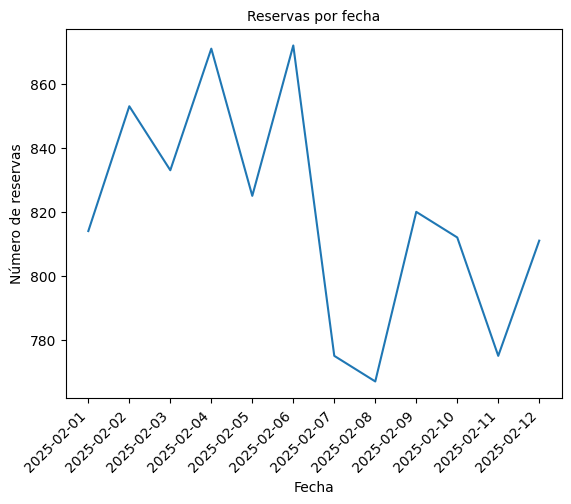

In [14]:
sns.lineplot(x = "fecha_reserva",
              y = "cantidad_reservas",
              data = df_fechas)

plt.title(f"Reservas por fecha", fontsize = 10)
plt.xlabel("Fecha", fontsize = 10)
plt.ylabel("Número de reservas", fontsize = 10)
plt.xticks(df_fechas["fecha_reserva"], rotation=45, ha='right')
# Mostrar el gráfico
plt.show()

## Análisis de ingresos y reservas por hotel en hoteles propios

In [18]:
query_analizar_propios = """SELECT nombre_hotel, sum(precio_noche), count(id_reserva)
                            FROM "Vista_hoteles_propios"
                            GROUP BY nombre_hotel
                            ORDER BY count(id_reserva) DESC;"""

cur.execute(query_analizar_propios)
datos_analizar_propios = cur.fetchall()
df_analizar_propios = pd.DataFrame(datos_analizar_propios, columns = ["nombre_hotel", "ingresos", "reservas"])
df_analizar_propios

,nombre_hotel,ingresos,reservas
0,Hotel Sol y Luna,149237.766793,557
1,Hotel Monte Verde,152136.809524,550
2,Hotel Luz de Madrid,144685.485607,536
3,Hotel Brisas del Mar,146970.641842,534
4,Hotel Los Almendros,145915.665951,533
5,Hotel Mirador Real,145661.051096,533
6,Hotel Puerta del Cielo,147359.553728,526
7,Hotel Camino del Sol,139859.193774,518
8,Gran Hotel Madrid,137252.991495,518
9,Hotel Costa Azul,146405.725926,515


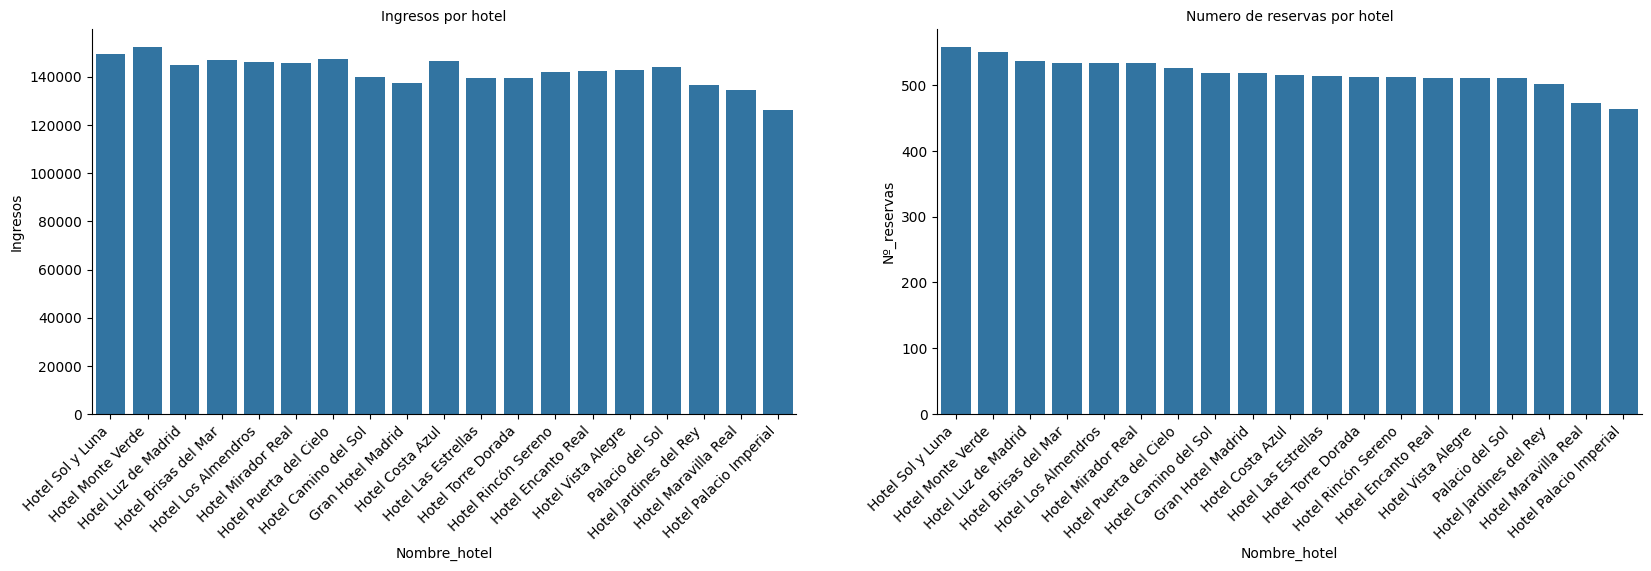

In [19]:
# Generamos 2 gráficos en subplots para ver si hay relación entre el número de reservas y los ingresos por hotel
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.barplot(x = "nombre_hotel", 
            y = "ingresos",
            data = df_analizar_propios,
            ax = axes[0])
sns.barplot(x = "nombre_hotel", 
            y = "reservas",
            data = df_analizar_propios, 
            ax = axes[1])

axes[0].set_title(f"Ingresos por hotel", fontsize = 10)
axes[0].set_xlabel("Nombre_hotel", fontsize = 10)
axes[0].set_ylabel("Ingresos", fontsize = 10)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_xticks(range(len(df_analizar_propios["nombre_hotel"])))
axes[0].set_xticklabels(labels = df_analizar_propios["nombre_hotel"], rotation=45, ha='right')


axes[1].set_title(f"Numero de reservas por hotel", fontsize = 10)
axes[1].set_ylabel("Nº_reservas", fontsize = 10)
axes[1].set_xlabel("Nombre_hotel", fontsize = 10)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_xticks(range(len(df_analizar_propios["nombre_hotel"])))
axes[1].set_xticklabels(labels = df_analizar_propios["nombre_hotel"], rotation=45, ha='right')

plt.show()

## Análisis de ingresos y reservas por hotel en hoteles de la competencia

In [20]:
query_analizar_competencia = """SELECT nombre_hotel, sum(precio_noche), count(id_reserva)
                            FROM "Vista_hoteles_competencia"
                            GROUP BY nombre_hotel
                            ORDER BY count(id_reserva) DESC;"""

cur.execute(query_analizar_competencia)
datos_analizar_competencia = cur.fetchall()
df_analizar_competencia = pd.DataFrame(datos_analizar_competencia, columns = ["nombre_hotel", "ingresos", "reservas"])
df_analizar_competencia

,nombre_hotel,ingresos,reservas
0,ibis budget Madrid Centro las Ventas,63903.0,537
1,ibis budget Madrid Vallecas,54366.0,533
2,ibis Madrid Alcorcon Tresaguas,50350.0,530
3,ibis Madrid Centro las Ventas,94844.0,524
4,ibis budget Madrid Aeropuerto,50634.0,522
5,ibis Madrid Alcobendas,46102.0,518
6,ibis Styles Madrid Prado,92185.0,515
7,ibis budget Madrid Calle 30,54166.0,511
8,ibis Madrid Aeropuerto Barajas,63597.0,493
9,ibis budget Madrid Alcorcon Móstoles,37653.0,489


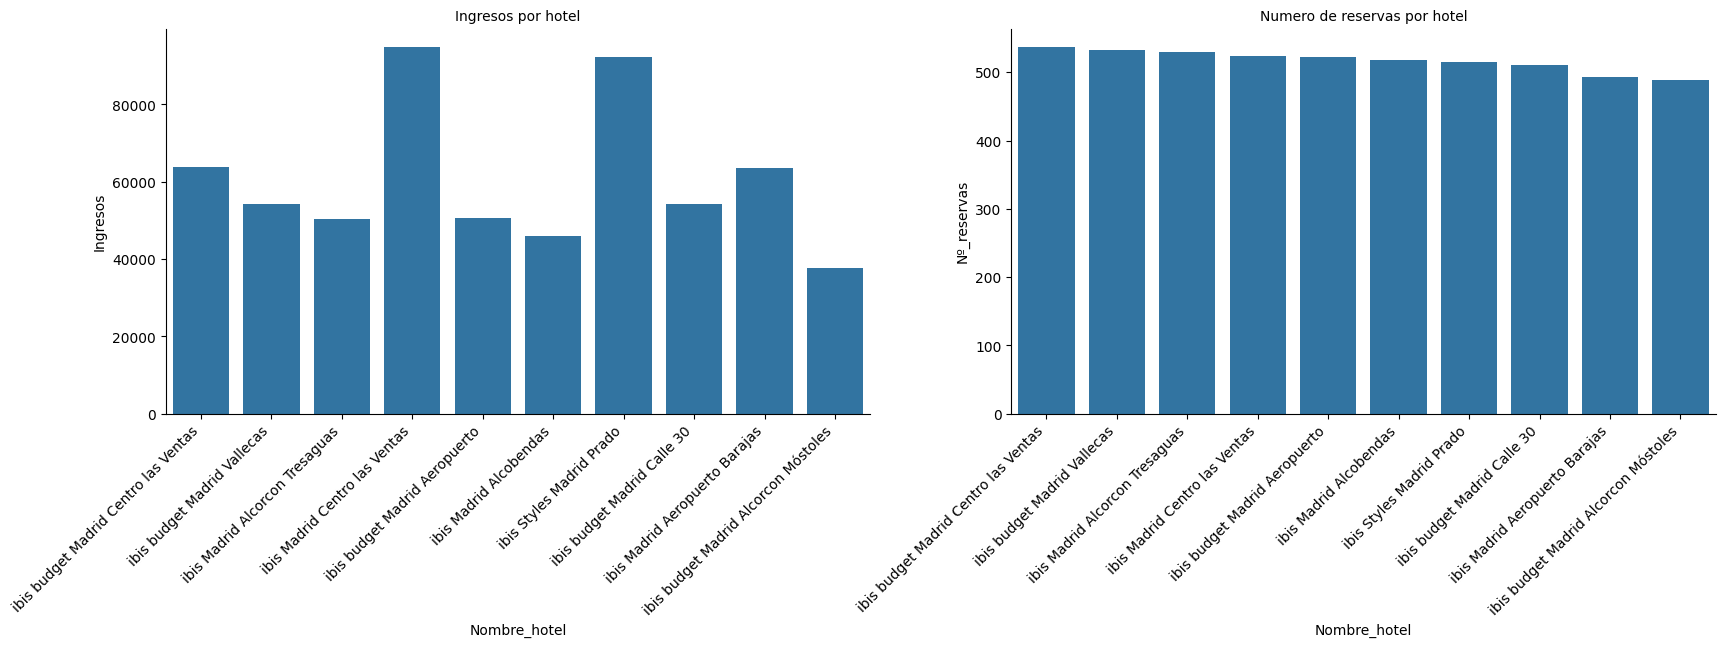

In [21]:
# Generamos 2 gráficos en subplots para ver si hay relación entre el número de reservas y los ingresos por hotel
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.barplot(x = "nombre_hotel", 
            y = "ingresos",
            data = df_analizar_competencia,
            ax = axes[0])
sns.barplot(x = "nombre_hotel", 
            y = "reservas",
            data = df_analizar_competencia, 
            ax = axes[1])

axes[0].set_title(f"Ingresos por hotel", fontsize = 10)
axes[0].set_xlabel("Nombre_hotel", fontsize = 10)
axes[0].set_ylabel("Ingresos", fontsize = 10)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_xticks(range(len(df_analizar_competencia["nombre_hotel"])))
axes[0].set_xticklabels(labels = df_analizar_competencia["nombre_hotel"], rotation=45, ha='right')


axes[1].set_title(f"Numero de reservas por hotel", fontsize = 10)
axes[1].set_ylabel("Nº_reservas", fontsize = 10)
axes[1].set_xlabel("Nombre_hotel", fontsize = 10)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_xticks(range(len(df_analizar_competencia["nombre_hotel"])))
axes[1].set_xticklabels(labels = df_analizar_competencia["nombre_hotel"], rotation=45, ha='right')

plt.show()